### Heat Capacity SC Lab

In [4]:
import os
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit

#### 0. Addenda measurements and calibration

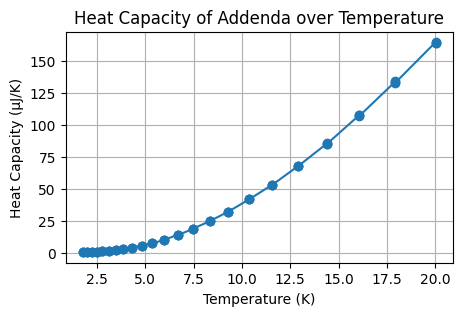

In [6]:
# Load the Excel file
file_path = 'AddendumHC.xlsx'
df = pd.read_excel(file_path, sheet_name='AddendumHC')

# Clean the data
# Convert Temperature and Addenda Offset HC columns to numeric, forcing errors to NaN
df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
df['Addenda HC'] = pd.to_numeric(df['Addenda HC'], errors='coerce')

# Drop rows with NaN values in the relevant columns
df = df.dropna(subset=['Temperature', 'Addenda HC'])

# Plot the data
plt.figure(figsize=(5, 3))
plt.plot(df['Temperature'], df['Addenda HC'], marker='o', linestyle='-')
plt.xlabel('Temperature (K)')
plt.ylabel('Heat Capacity (µJ/K)')
plt.title('Heat Capacity of Addenda over Temperature')
plt.grid(True)
plt.show()


#### 1. Zero-field heat capacity demonstrating the superconducting transition

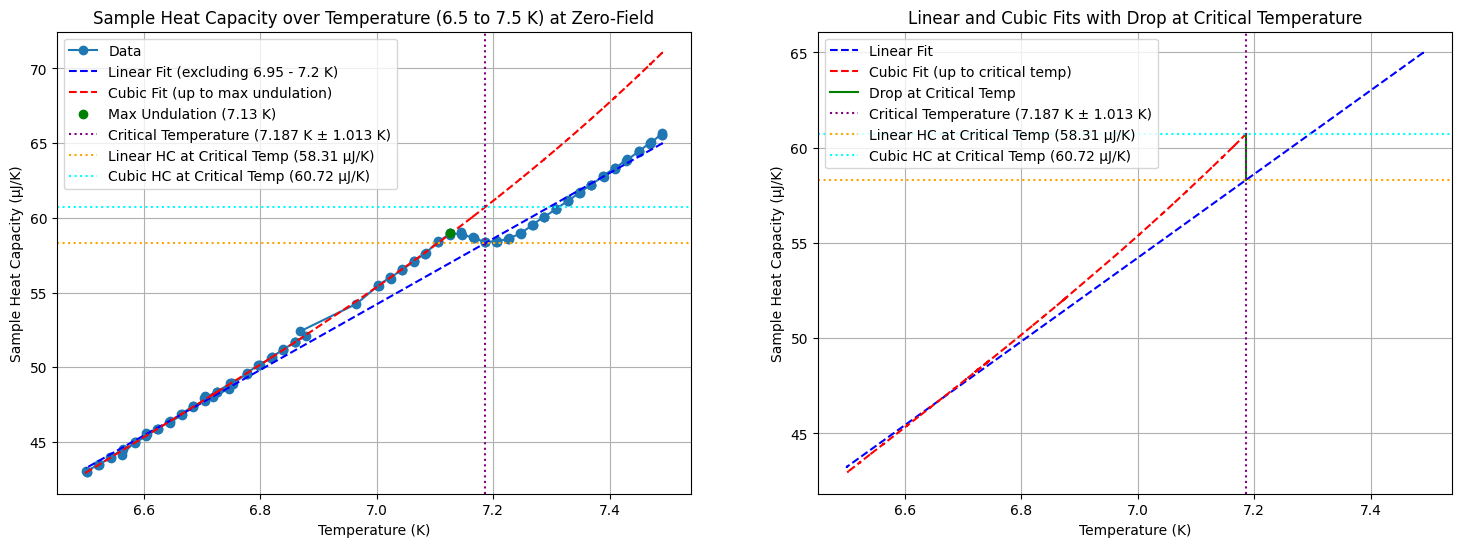

Critical temperature of lead at zero-field: 7.187 K ± 1.013 K
Heat capacity at critical temperature (linear fit): 58.31 µJ/K
Heat capacity at critical temperature (cubic fit): 60.72 µJ/K
Difference in heat capacity at critical temperature: 2.4132 µJ/K


In [27]:
# Load the data
file_path_new = 'LeadHC at zero-field.xlsx'
df_new = pd.read_excel(file_path_new)

# Convert Temperature and Sample HC columns to numeric, forcing errors to NaN
df_new['Temperature'] = pd.to_numeric(df_new['Sample Temp'], errors='coerce')
df_new['Total HC'] = pd.to_numeric(df_new['Total HC'], errors='coerce')
df_new['Addenda HC'] = pd.to_numeric(df_new['Addenda HC'], errors='coerce')
df_new['Samp HC Err'] = pd.to_numeric(df_new['Samp HC Err'], errors='coerce')

df_new['Corrected HC'] = df_new['Total HC'] - df_new['Addenda HC']

# Filter the data to include only the temperature range from 6.5 to 7.5 Kelvin
df_filtered = df_new[(df_new['Temperature'] >= 6.5) & (df_new['Temperature'] <= 7.5)]

# Further filter out the points between 6.95 and 7.2 Kelvin for the linear fit
df_linear_fit = df_filtered[(df_filtered['Temperature'] < 6.95) | (df_filtered['Temperature'] > 7.2)]

# Perform a weighted linear fit on the filtered data
weights = 1 / df_linear_fit['Samp HC Err']
fit_params_linear, cov_matrix_linear = np.polyfit(df_linear_fit['Temperature'], df_linear_fit['Corrected HC'], 1, w=weights, cov=True)
fit_line_linear = np.polyval(fit_params_linear, df_filtered['Temperature'])

# Calculate undulations
undulations = df_filtered['Corrected HC'] - fit_line_linear

# Find the index of the maximum undulation point
max_undulation_index = undulations.idxmax()
max_undulation_temp = df_filtered['Temperature'].loc[max_undulation_index]

# Filter the data to include points up to the max undulation temperature for the cubic fit
df_fit_cubic = df_filtered[df_filtered['Temperature'] <= max_undulation_temp]

# Perform a weighted cubic fit on the filtered data up to the max undulation temperature
weights_cubic = 1 / df_fit_cubic['Samp HC Err']
fit_params_cubic, cov_matrix_cubic = np.polyfit(df_fit_cubic['Temperature'], df_fit_cubic['Corrected HC'], 3, w=weights_cubic, cov=True)
fit_line_cubic = np.polyval(fit_params_cubic, df_filtered['Temperature'])

# Find the point in the range 7.15 to 7.25 where undulations from the linear fit are minimal
df_range = df_filtered[(df_filtered['Temperature'] >= 7.15) & (df_filtered['Temperature'] <= 7.22)]
min_undulation_index = (df_range['Corrected HC'] - np.polyval(fit_params_linear, df_range['Temperature'])).abs().idxmin()
critical_temp = df_filtered['Temperature'].loc[min_undulation_index]

# Estimate the error in the critical temperature
linear_fit_errors = np.sqrt(np.diag(cov_matrix_linear))
cubic_fit_errors = np.sqrt(np.diag(cov_matrix_cubic))
critical_temp_error = np.sqrt((linear_fit_errors[0] * critical_temp)**2 + linear_fit_errors[1]**2)

# Calculate heat capacity difference at the critical temperature
hc_linear_at_critical = np.polyval(fit_params_linear, critical_temp)
hc_cubic_at_critical = np.polyval(fit_params_cubic, critical_temp)
hc_difference = hc_cubic_at_critical - hc_linear_at_critical

# Plot the data, linear fit, and cubic fit
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Original plot
ax1.plot(df_filtered['Temperature'], df_filtered['Corrected HC'], marker='o', linestyle='-', label='Data')
ax1.plot(df_filtered['Temperature'], fit_line_linear, linestyle='--', color='blue', label='Linear Fit (excluding 6.95 - 7.2 K)')
ax1.plot(df_filtered['Temperature'], fit_line_cubic, linestyle='--', color='red', label='Cubic Fit (up to max undulation)')
ax1.scatter([max_undulation_temp], [df_filtered['Corrected HC'].loc[max_undulation_index]], color='green', zorder=5, label=f'Max Undulation ({max_undulation_temp:.2f} K)')
ax1.axvline(x=critical_temp, color='purple', linestyle=':', label=f'Critical Temperature ({critical_temp:.3f} K ± {critical_temp_error:.3f} K)')
ax1.axhline(y=hc_linear_at_critical, color='orange', linestyle=':', label=f'Linear HC at Critical Temp ({hc_linear_at_critical:.2f} µJ/K)')
ax1.axhline(y=hc_cubic_at_critical, color='cyan', linestyle=':', label=f'Cubic HC at Critical Temp ({hc_cubic_at_critical:.2f} µJ/K)')
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('Sample Heat Capacity (µJ/K)')
ax1.set_title('Sample Heat Capacity over Temperature (6.5 to 7.5 K) at Zero-Field')
ax1.grid(True)
ax1.legend()

# New plot with the specific parts
ax2.plot(df_filtered['Temperature'], fit_line_linear, linestyle='--', color='blue', label='Linear Fit')
ax2.plot(df_filtered['Temperature'][df_filtered['Temperature'] <= critical_temp], 
         np.polyval(fit_params_cubic, df_filtered['Temperature'][df_filtered['Temperature'] <= critical_temp]), 
         linestyle='--', color='red', label='Cubic Fit (up to critical temp)')
ax2.plot([critical_temp, critical_temp], [hc_cubic_at_critical, hc_linear_at_critical], linestyle='-', color='green', label='Drop at Critical Temp')
ax2.axvline(x=critical_temp, color='purple', linestyle=':', label=f'Critical Temperature ({critical_temp:.3f} K ± {critical_temp_error:.3f} K)')
ax2.axhline(y=hc_linear_at_critical, color='orange', linestyle=':', label=f'Linear HC at Critical Temp ({hc_linear_at_critical:.2f} µJ/K)')
ax2.axhline(y=hc_cubic_at_critical, color='cyan', linestyle=':', label=f'Cubic HC at Critical Temp ({hc_cubic_at_critical:.2f} µJ/K)')
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel('Sample Heat Capacity (µJ/K)')
ax2.set_title('Linear and Cubic Fits with Drop at Critical Temperature')
ax2.grid(True)
ax2.legend()

plt.show()

print(f"Critical temperature of lead at zero-field: {critical_temp:.3f} K ± {critical_temp_error:.3f} K")
print(f"Heat capacity at critical temperature (linear fit): {hc_linear_at_critical:.2f} µJ/K")
print(f"Heat capacity at critical temperature (cubic fit): {hc_cubic_at_critical:.2f} µJ/K")
print(f"Difference in heat capacity at critical temperature: {hc_difference:.4f} µJ/K")


#### 2. Heat capacity measured in intermediate fields to determine Bc(T), extending the B-T phase diagram.

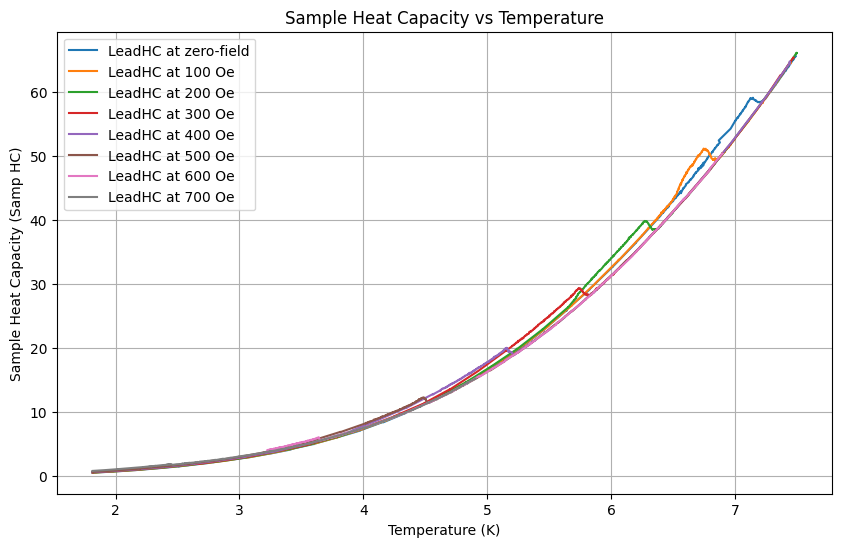

In [2]:
# List of filenames
file_names = [
    "LeadHC at zero-field.xlsx",
    "LeadHC at 100 Oe.xlsx",
    "LeadHC at 200 Oe.xlsx",
    "LeadHC at 300 Oe.xlsx",
    "LeadHC at 400 Oe.xlsx",
    "LeadHC at 500 Oe.xlsx",
    "LeadHC at 600 Oe.xlsx",
    "LeadHC at 700 Oe.xlsx"
]

# Dictionary to store data from each file
data = {}

# Load the data from each file
for file_name in file_names:
    data[file_name] = pd.read_excel(file_name)

# Plotting
plt.figure(figsize=(10, 6))

for file_name, df in data.items():
    # Ensure 'Temperature' column is numeric
    df['Temperature'] = pd.to_numeric(df['Sample Temp'], errors='coerce')
    df['Total HC'] = pd.to_numeric(df['Total HC'], errors='coerce')
    df['Addenda HC'] = pd.to_numeric(df['Addenda HC'], errors='coerce')
    
    df['Corrected HC'] = df['Total HC'] - df['Addenda HC']
    
    # Filter the temperature range
    df_filtered = df[(df['Temperature'] >= 1) & (df['Temperature'] <= 7.5)]
    
    plt.plot(df_filtered['Temperature'], df_filtered['Corrected HC'], label=file_name.split('.')[0])

plt.xlabel('Temperature (K)')
plt.ylabel('Sample Heat Capacity (Samp HC)')
plt.title('Sample Heat Capacity vs Temperature')
plt.legend()
plt.grid(True)
plt.show()


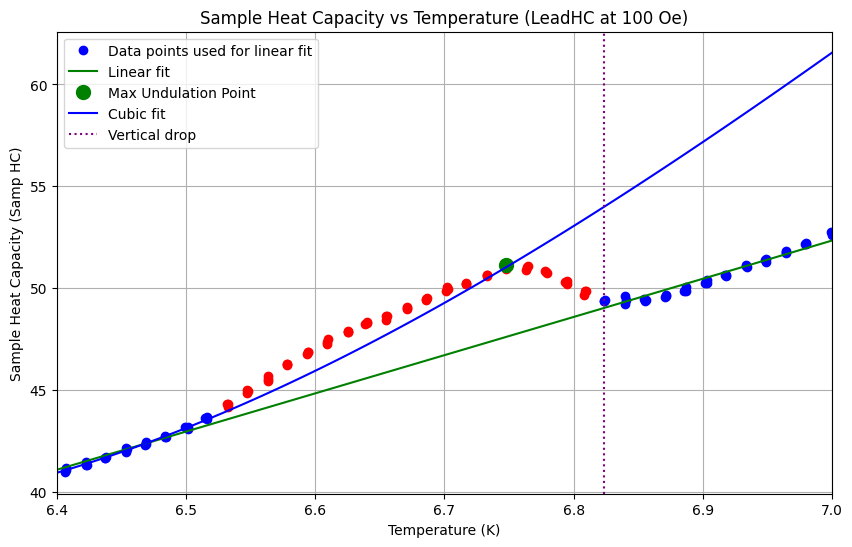

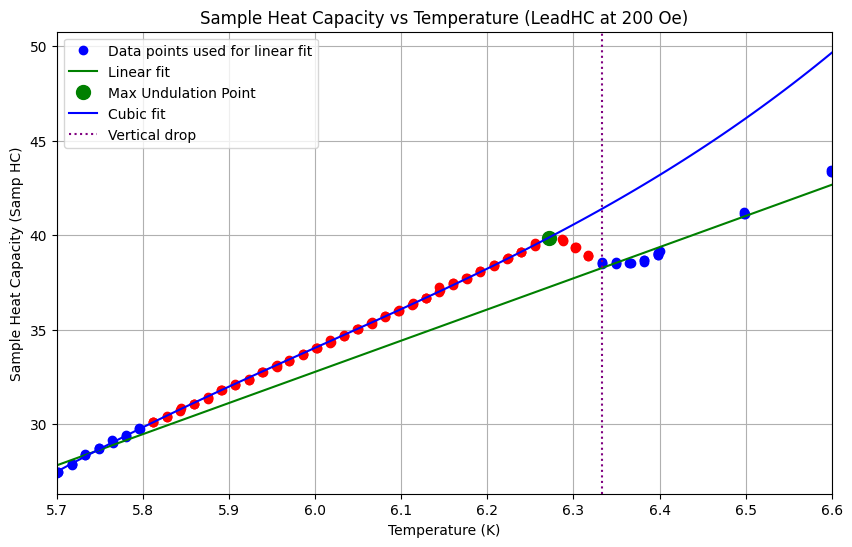

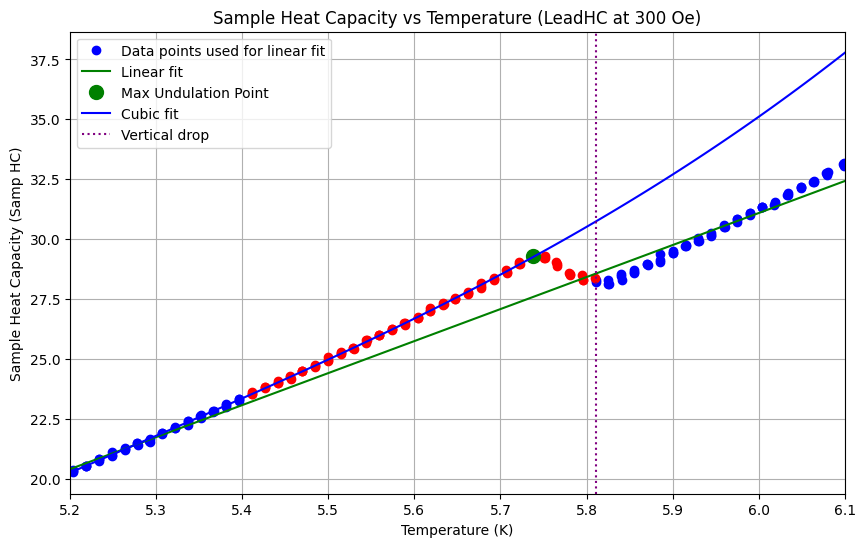

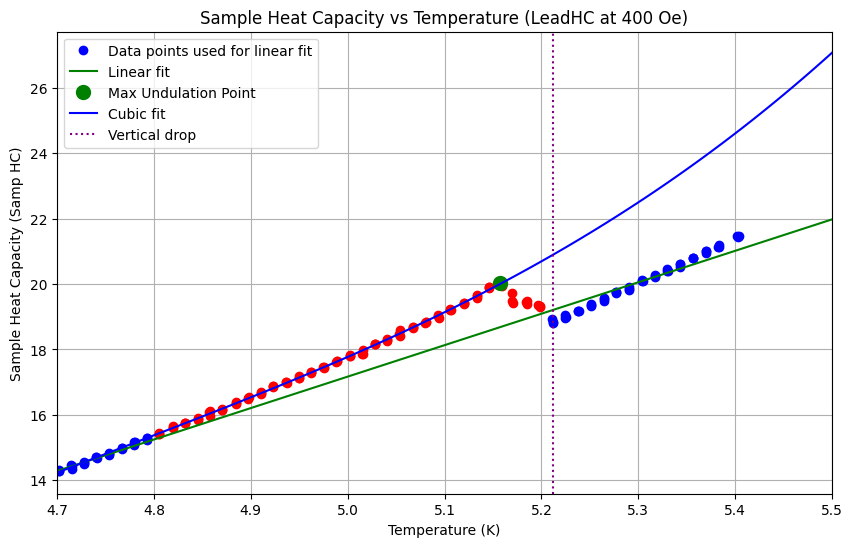

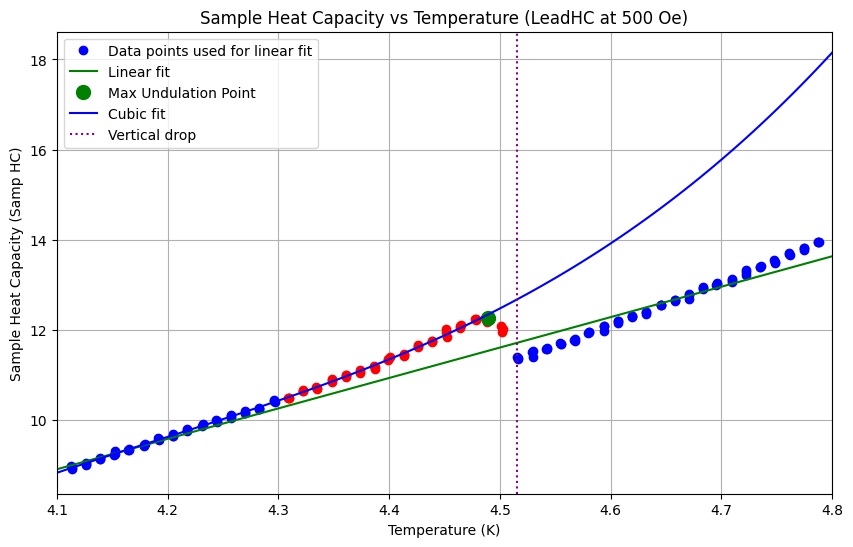

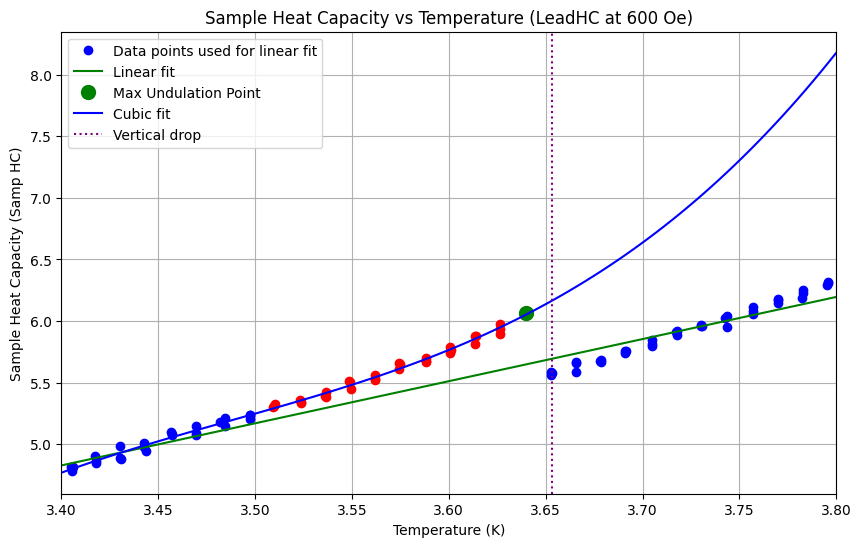

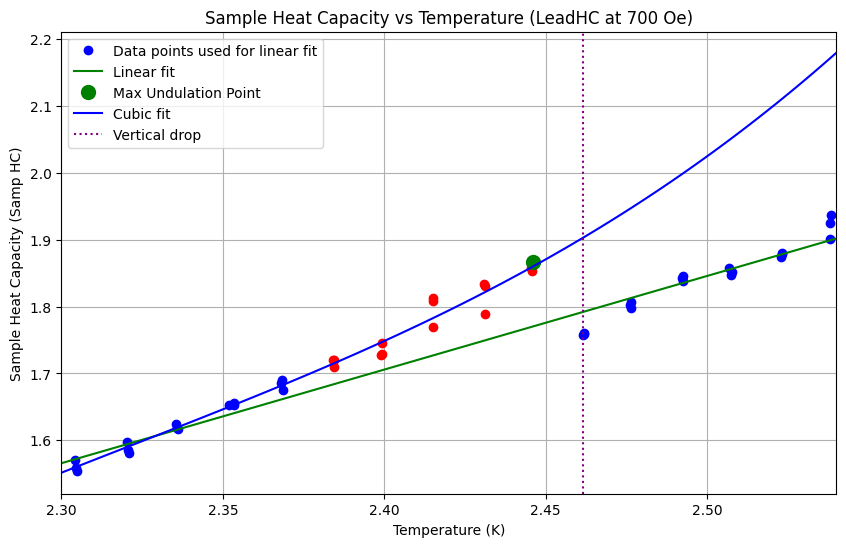

Critical Temperatures and HC Differences:
LeadHC at 100 Oe.xlsx: Critical Temperature = 6.824 K, HC Difference = 4.967
LeadHC at 200 Oe.xlsx: Critical Temperature = 6.333 K, HC Difference = 3.132
LeadHC at 300 Oe.xlsx: Critical Temperature = 5.811 K, HC Difference = 2.179
LeadHC at 400 Oe.xlsx: Critical Temperature = 5.212 K, HC Difference = 1.690
LeadHC at 500 Oe.xlsx: Critical Temperature = 4.515 K, HC Difference = 0.961
LeadHC at 600 Oe.xlsx: Critical Temperature = 3.653 K, HC Difference = 0.471
LeadHC at 700 Oe.xlsx: Critical Temperature = 2.462 K, HC Difference = 0.111


In [5]:
# Linear function to fit
def linear_func(x, a, b):
    return a * x + b

# Cubic function to fit
def cubic_func(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

file_names = [
    "LeadHC at 100 Oe.xlsx",
    "LeadHC at 200 Oe.xlsx",
    "LeadHC at 300 Oe.xlsx",
    "LeadHC at 400 Oe.xlsx",
    "LeadHC at 500 Oe.xlsx",
    "LeadHC at 600 Oe.xlsx",
    "LeadHC at 700 Oe.xlsx"
]

fit_ranges = [
    (6.4, 7, 6.53, 6.81),
    (5.7, 6.6, 5.8, 6.33),
    (5.2, 6.1, 5.4, 5.81),
    (4.7, 5.5, 4.8, 5.21),
    (4.1, 4.8, 4.3, 4.51),
    (3.4, 3.8, 3.5, 3.65),
    (2.3, 2.54, 2.38, 2.45)
]

# Dictionary to store data from each file
data = {}

# Load the data from each file
for file_name in file_names:
    if os.path.exists(file_name):
        data[file_name] = pd.read_excel(file_name)
    else:
        print(f"File {file_name} not found!")

# List to store critical temperature and HC difference for each field
critical_temperatures = []
hc_differences = []

# Plotting each file separately with linear fits and cubic fits
for i, (file_name, df) in enumerate(data.items()):
    # Ensure 'Temperature' column is numeric
    df['Temperature'] = pd.to_numeric(df['Sample Temp'], errors='coerce')
    df['Total HC'] = pd.to_numeric(df['Total HC'], errors='coerce')
    df['Addenda HC'] = pd.to_numeric(df['Addenda HC'], errors='coerce')
    
    df['Corrected HC'] = df['Total HC'] - df['Addenda HC']
    
    # Filter the temperature range for plotting
    fit_start, fit_end, exclude_start, exclude_end = fit_ranges[i]
    df_range = df[(df['Temperature'] >= fit_start) & (df['Temperature'] <= fit_end)]
    
    # Further filter the temperature range for fitting with exclusion
    df_fit_range = df_range[~((df_range['Temperature'] >= exclude_start) & (df_range['Temperature'] <= exclude_end))]
    
    # Extract the points that are specifically skipped
    df_excluded = df_range[(df_range['Temperature'] >= exclude_start) & (df_range['Temperature'] <= exclude_end)]
    
    # Perform the linear fit with error correction
    popt_linear, pcov_linear = curve_fit(linear_func, df_fit_range['Temperature'], df_fit_range['Corrected HC'], sigma=df_fit_range['Samp HC Err'], absolute_sigma=True)
    x_fit_linear = np.linspace(fit_start, fit_end, 100)
    y_fit_linear = linear_func(x_fit_linear, *popt_linear)
    
    # Find the maximum undulation point in the excluded area
    if not df_excluded.empty:
        max_undulation_point = df_excluded.loc[df_excluded['Corrected HC'].idxmax()]
        max_undulation_temp = max_undulation_point['Temperature']
        max_undulation_hc = max_undulation_point['Corrected HC']
        
        # Perform the cubic fit up to the maximum undulation point with error correction
        df_cubic_range = df[(df['Temperature'] >= fit_start) & (df['Temperature'] <= max_undulation_temp)]
        
        # Additional exclusion zones for cubic fit
        if file_name == "LeadHC at 100 Oe.xlsx":
            df_cubic_range = df_cubic_range[~((df_cubic_range['Temperature'] >= 6.5) & (df_cubic_range['Temperature'] <= 6.745))]
        elif file_name == "LeadHC at 200 Oe.xlsx":
            df_cubic_range = df_cubic_range[~((df_cubic_range['Temperature'] >= 5.75) & (df_cubic_range['Temperature'] <= 6))]
        
        popt_cubic, pcov_cubic = curve_fit(cubic_func, df_cubic_range['Temperature'], df_cubic_range['Corrected HC'], sigma=df_cubic_range['Samp HC Err'], absolute_sigma=True)
        x_fit_cubic = np.linspace(fit_start, fit_end, 100)
        y_fit_cubic = cubic_func(x_fit_cubic, *popt_cubic)
    else:
        max_undulation_temp = None
        max_undulation_hc = None

    # Find the last data point after the exclusion range
    df_after_exclusion = df_range[df_range['Temperature'] > exclude_end]
    if not df_after_exclusion.empty:
        last_after_exclusion = df_after_exclusion.iloc[-1]
        last_after_exclusion_temp = last_after_exclusion['Temperature']
        last_after_exclusion_hc = last_after_exclusion['Corrected HC']
    else:
        last_after_exclusion_temp = None
        last_after_exclusion_hc = None

    # Calculate HC difference at the critical temperature
    if last_after_exclusion_temp is not None:
        critical_temp = last_after_exclusion_temp
        hc_cubic = cubic_func(critical_temp, *popt_cubic)
        hc_linear = linear_func(critical_temp, *popt_linear)
        hc_difference = hc_cubic - hc_linear
        
        # Store the critical temperature and HC difference
        critical_temperatures.append((file_name, critical_temp, hc_difference))

    # Plot the data and the fits within the fitting range
    plt.figure(figsize=(10, 6))
    plt.plot(df_fit_range['Temperature'], df_fit_range['Corrected HC'], 'bo', label='Data points used for linear fit')
    plt.plot(df_excluded['Temperature'], df_excluded['Corrected HC'], 'ro')
    plt.plot(x_fit_linear, y_fit_linear, 'g-', label=f'Linear fit')
    
    # Highlight the maximum undulation point in green if it exists
    if max_undulation_temp is not None:
        plt.plot(max_undulation_temp, max_undulation_hc, 'go', markersize=10, label='Max Undulation Point')
        plt.plot(x_fit_cubic, y_fit_cubic, 'b-', label=f'Cubic fit')
        
    # Draw vertical line at the last data point after exclusion range if it exists
    if last_after_exclusion_temp is not None:
        plt.axvline(x=last_after_exclusion_temp, color='purple', linestyle='dotted', label='Vertical drop')
        
    plt.xlabel('Temperature (K)')
    plt.ylabel('Sample Heat Capacity (Samp HC)')
    plt.title(f'Sample Heat Capacity vs Temperature ({file_name.split(".")[0]})')
    plt.xlim(fit_start, fit_end)
    plt.legend()
    plt.grid(True)
    plt.show()

# Print critical temperatures and HC differences
print("Critical Temperatures and HC Differences:")
for file_name, critical_temp, hc_difference in critical_temperatures:
    print(f"{file_name}: Critical Temperature = {critical_temp:.3f} K, HC Difference = {hc_difference:.3f}")


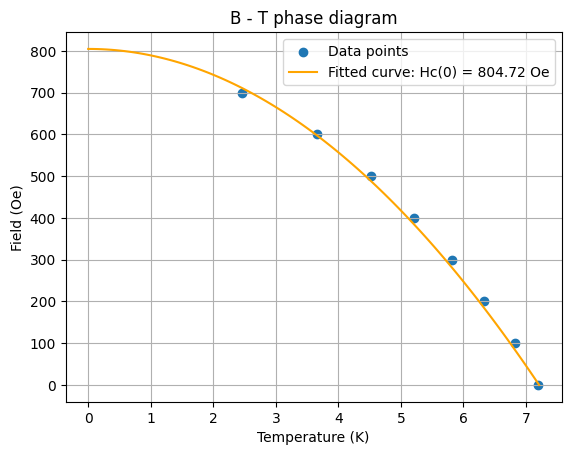

Critical field Hc(0) = 804.72 Oe


In [10]:
# Data
field = [700, 600, 500, 400, 300, 200, 100, 0]
temperature = [2.462, 3.653, 4.515, 5.212, 5.811, 6.333, 6.824, 7.187]

# Given values
T_c = 7.21
temperature_range = np.linspace(0, T_c, 100)
H_0 = 700  # Field at T = 0 (initial guess to be refined later)


# Define the function for curve fitting
def H_c_fit(T, H_0, T_c):
    return H_0 * (1 - (T / T_c)**2)

# Fit the curve
popt, _ = curve_fit(H_c_fit, temperature, field, p0=[800, T_c])
H_0_fitted = popt[0]

# Calculate field values with the fitted parameters
field_values_fitted = H_c_fit(temperature_range, H_0_fitted, T_c)

# Plotting the data points and the fitted curve
plt.scatter(temperature, field, label='Data points')
plt.plot(temperature_range, field_values_fitted, color='orange', label=f'Fitted curve: Hc(0) = {H_0_fitted:.2f} Oe')
plt.xlabel('Temperature (K)')
plt.ylabel('Field (Oe)')
plt.title('B - T phase diagram')
plt.legend()
plt.grid(True)
plt.show()

print(f'Critical field Hc(0) = {H_0_fitted:.2f} Oe')

#### 3. Heat capacity in the normal state, the estimation of the Sommerfeld coefficient. 

C:\Users\mkana\Desktop\Studies\Labs\Heat Capacity\pythonProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\mkana\Desktop\Studies\Labs\Heat Capacity\pythonProject\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


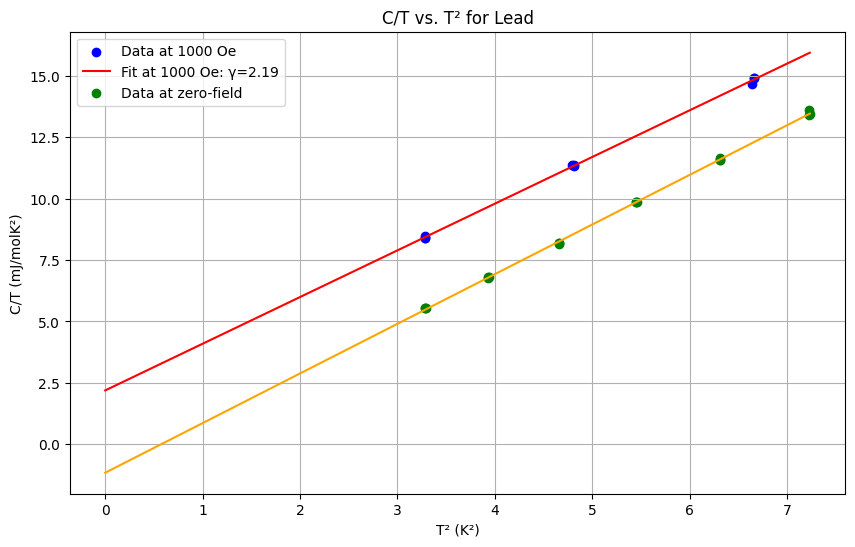

Sommerfeld coefficient (γ) at 1000 Oe: 2.1894 mJ mole^-1 K^-2


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Constants
mass_mg = 10.8  # mass of the sample in mg
mass_g = mass_mg / 1000  # convert mass to grams
molar_mass_pb = 207.2  # molar mass of lead in g/mol

# File paths
file_1000_oe = 'LeadHC at 1000 Oe.xlsx'
file_zero_field = 'LeadHC at zero-field.xlsx'

# Function to process the data
def process_file(file_name):
    # Read the Excel file
    df = pd.read_excel(file_name)
    
    # Ensure necessary columns are present
    if 'Total HC' in df.columns and 'Addenda HC' in df.columns and 'Sample Temp' in df.columns:
        # Convert columns to numeric, forcing errors to NaN
        df['Total HC'] = pd.to_numeric(df['Total HC'], errors='coerce')
        df['Addenda HC'] = pd.to_numeric(df['Addenda HC'], errors='coerce')
        df['Temperature'] = pd.to_numeric(df['Sample Temp'], errors='coerce')
        
        # Drop rows with NaN values (caused by conversion errors)
        df = df.dropna(subset=['Total HC', 'Addenda HC', 'Temperature'])
        
        # Calculate the corrected HC
        df['Corrected HC'] = df['Total HC'] - df['Addenda HC']
        
        # Filter by temperature range below 3 Kelvin
        df = df[df['Temperature'] < 2.7]
        
        # Convert temperature to K^2
        df['Temperature K^2'] = df['Temperature'] ** 2
        
        # Scale HC to mJ/molK^2
        df['Corrected HC mJ/molK^2'] = ((df['Corrected HC'] * molar_mass_pb / 1000) / mass_g)/df['Temperature']
        
        return df[['Temperature K^2', 'Corrected HC mJ/molK^2']]
    else:
        raise ValueError(f"File {file_name} does not contain the required columns.")

# Process both files
data_1000_oe = process_file(file_1000_oe)
data_zero_field = process_file(file_zero_field)

# Prepare the data for fitting
data_1000_oe['C/T'] = data_1000_oe['Corrected HC mJ/molK^2']
data_zero_field['C/T'] = data_zero_field['Corrected HC mJ/molK^2']

# Fit the data using linear regression for both datasets
model_1000_oe = LinearRegression().fit(data_1000_oe[['Temperature K^2']], data_1000_oe['C/T'])
model_zero_field = LinearRegression().fit(data_zero_field[['Temperature K^2']], data_zero_field['C/T'])

# Extract the Sommerfeld coefficient (intercept)
gamma_1000_oe = model_1000_oe.intercept_
gamma_zero_field = model_zero_field.intercept_

# Generate values for the fit line extending to zero
temp_k2_range = np.linspace(0, max(data_1000_oe['Temperature K^2'].max(), data_zero_field['Temperature K^2'].max()), 100).reshape(-1, 1)

# Plot the data and the linear fit
plt.figure(figsize=(10, 6))

# Plot for 1000 Oe
plt.scatter(data_1000_oe['Temperature K^2'], data_1000_oe['C/T'], label='Data at 1000 Oe', color='blue')
plt.plot(temp_k2_range, model_1000_oe.predict(temp_k2_range), color='red', label=f'Fit at 1000 Oe: γ={gamma_1000_oe:.2f}')

# Plot for zero-field
plt.scatter(data_zero_field['Temperature K^2'], data_zero_field['C/T'], label='Data at zero-field', color='green')
plt.plot(temp_k2_range, model_zero_field.predict(temp_k2_range), color='orange')

# Customize the plot
plt.title('C/T vs. T² for Lead')
plt.xlabel('T² (K²)')
plt.ylabel('C/T (mJ/molK²)')
plt.legend()
plt.grid(True)
plt.show()


print(f"Sommerfeld coefficient (γ) at 1000 Oe: {gamma_1000_oe:.4f} mJ mole^-1 K^-2")


#### 5. Analyze the jump at zero field heat capacity at the superconducting transition. Compare to BCS theory. 

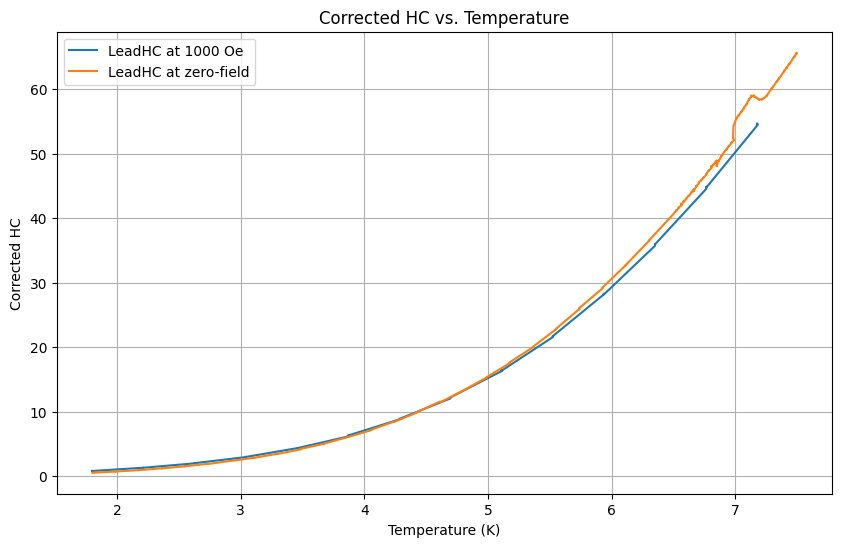

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
file_1000_oe = 'LeadHC at 1000 Oe.xlsx'
file_zero_field = 'LeadHC at zero-field.xlsx'

# Function to process the data
def process_file(file_name):
    # Read the Excel file
    df = pd.read_excel(file_name)
    
    # Ensure necessary columns are present
    if 'Total HC' in df.columns and 'Addenda HC' in df.columns and 'Temperature' in df.columns:
        # Convert columns to numeric, forcing errors to NaN
        df['Total HC'] = pd.to_numeric(df['Total HC'], errors='coerce')
        df['Addenda HC'] = pd.to_numeric(df['Addenda HC'], errors='coerce')
        df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
        
        # Drop rows with NaN values (caused by conversion errors)
        df = df.dropna(subset=['Total HC', 'Addenda HC', 'Temperature'])
        
        # Calculate the corrected HC
        df['Corrected HC'] = df['Total HC'] - df['Addenda HC']
        
        # Filter by temperature range
        df = df[df['Temperature'] <= 7.5]
        return df[['Temperature', 'Corrected HC']]
    else:
        raise ValueError(f"File {file_name} does not contain the required columns.")

# Process both files
data_1000_oe = process_file(file_1000_oe)
data_zero_field = process_file(file_zero_field)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data_1000_oe['Temperature'], data_1000_oe['Corrected HC'], label='LeadHC at 1000 Oe')
plt.plot(data_zero_field['Temperature'], data_zero_field['Corrected HC'], label='LeadHC at zero-field')

# Customize the plot
plt.title('Corrected HC vs. Temperature')
plt.xlabel('Temperature (K)')
plt.ylabel('Corrected HC')
plt.legend()
plt.grid(True)
plt.show()
